# Allelic ATAC validation

Workflow for summarising ASPEN beta-binomial outputs, coverage QC, regulatory context, and peak–gene concordance for allelic ATAC signals.

In [8]:
## Load libraries
suppressPackageStartupMessages({
  library(dplyr)
  library(tidyr)
  library(purrr)
  library(ggplot2)
  library(stringr)
  library(readr)
  library(tibble)
  library(SingleCellExperiment)
  library(Matrix)
  library(GenomeInfoDb)
  library(pkgload)
    library(Seurat)
  library(future)
  library(future.apply)
})
bioc_pkgs <- c("GenomicRanges", "GenomicFeatures", "GenomeInfoDb", "SingleCellExperiment", "scran", "rtracklayer", "Biostrings", "Rsamtools")
for (pkg in bioc_pkgs) {
  if (!suppressWarnings(require(pkg, quietly = TRUE, character.only = TRUE))) {
    stop(sprintf("Package %s is required; install it with BiocManager::install('%s')", pkg, pkg))
  }
}
theme_set(theme_bw())


## Configure paths and thresholds

In [9]:
base_dir <- "/g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/F1_AI/aspen"
pseudobulk_path <- "/g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/F1_AI/pseudobulk/allelic_counts_per_peak.tsv.gz"
motif_summary_path <- "/g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/F1_AI/motif/motif_ai_summary.tsv.gz"
motif_filtered_path <- "/g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/F1_AI/motif/motif_ai_filtered.tsv"
gtf_path <- "/g/data/zk16/muqing/Projects/Multiome/ref/BL6_T2T/geneset/genes.gtf"
if (file.exists('/g/data/zk16/muqing/Projects/Multiome/ref/BL6_ref/geneset_m39/t2t_gene_to_grcm39.tsv')) {
  gtf_gene_map_path <- '/g/data/zk16/muqing/Projects/Multiome/ref/BL6_ref/geneset_m39/t2t_gene_to_grcm39.tsv'
} else {
  gtf_gene_map_path <- NA_character_
}
gtf_gene_map_path <- "/g/data/zk16/muqing/Projects/Multiome/ref/BL6_ref/geneset_m39/t2t_gene_to_grcm39.tsv"
sce_path <- "/g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/atac_allelic_allcells_sce_sexupdated.rds"
ccre_path <- NA_character_
multiome_path <- "/g/data/zk16/muqing/Projects/Multiome/data/multiome/wnn_multiome_with_allelic_fracs_and_fixed_condition_ATACagg_wnn_sexupdated.rds"
asp_repo <- "/g/data/zk16/muqing/repos/ASPEN-GLM"
rna_ai_path <- NA_character_
filtered_fragment_dir <- "/g/data/zk16/muqing/Projects/Multiome/data/multiome/filtered_fragments"
gex_qc_dir <- "/g/data/zk16/muqing/Projects/Multiome/QC/GEX/per_sample_qc"
atac_qc_dir <- "/g/data/zk16/muqing/Projects/Multiome/QC/ATAC"
fragment_manifest_path <- file.path(filtered_fragment_dir, "filtered_fragments_manifest.tsv")
bsgenome_preference <- c('BSgenome.Mmusculus.T2T.C57BL6Jv1', 'BSgenome.Mmusculus.UCSC.mm10')
regionstats_fasta <- if (file.exists("/g/data/zk16/muqing/Projects/Multiome/ref/BL6_T2T/genome/softmasked.fa"))   "/g/data/zk16/muqing/Projects/Multiome/ref/BL6_T2T/genome/softmasked.fa" else NA_character_

fdr_cutoff <- 0.1
min_total_counts <- 50L
min_groups_per_peak <- 1L
run_linkpeaks <- TRUE

normalized_counts_path <- file.path(dirname(base_dir), "pseudobulk", "allelic_counts_per_peak_norm.tsv.gz")
normalized_aspen_dir <- file.path(dirname(base_dir), "aspen_norm")
min_cells_aspen <- 40L
max_peaks_aspen <- 10000L
run_normalised_aspen <- TRUE
write_normalised_counts <- TRUE
message("ASPEN result dir: ", base_dir)





ASPEN result dir: /g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/F1_AI/aspen



## Load pseudobulk allelic counts and normalise coverage

In [10]:
pb_counts <- NULL
if (file.exists(pseudobulk_path)) {
  message('Loading pseudobulk counts from ', pseudobulk_path)
  con <- gzfile(pseudobulk_path, open = 'rt')
  pb_counts <- read.csv(con, sep = '	', stringsAsFactors = FALSE)
  close(con)
  pb_counts <- pb_counts %>%
    mutate(
      group_id = group,
      total_counts = tot
    ) %>%
    group_by(group_id) %>%
    mutate(
      norm_tot = ifelse(sum(total_counts, na.rm = TRUE) > 0, total_counts / sum(total_counts, na.rm = TRUE) * 1e6, NA_real_),
      frac_a1 = ifelse(total_counts > 0, a1 / total_counts, NA_real_)
    ) %>%
    ungroup()
  pb_group_summary <- pb_counts %>%
    group_by(group_id, celltype, condition) %>%
    summarise(
      total_counts = sum(total_counts, na.rm = TRUE),
      n_peaks = dplyr::n(),
      median_tot = stats::median(total_counts, na.rm = TRUE),
      median_norm = stats::median(norm_tot, na.rm = TRUE),
      q1_tot = stats::quantile(total_counts, 0.25, na.rm = TRUE),
      q3_tot = stats::quantile(total_counts, 0.75, na.rm = TRUE)
    ) %>%
    ungroup() %>%
    arrange(desc(total_counts))
  pb_group_summary
} else {
  warning('Pseudobulk file not found: ', pseudobulk_path)
}



Loading pseudobulk counts from /g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/F1_AI/pseudobulk/allelic_counts_per_peak.tsv.gz

`summarise()` has grouped output by 'group_id', 'celltype'. You can override
using the `.groups` argument.


group_id,celltype,condition,total_counts,n_peaks,median_tot,median_norm,q1_tot,q3_tot
<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Cardiomyocyte|F1_Aged,Cardiomyocyte,F1_Aged,11092022,66217,11092022,4.147125,11092022,11092022
Cardiomyocyte|F1_Young,Cardiomyocyte,F1_Young,10877350,66217,10877350,3.125761,10877350,10877350
Fibroblast|F1_Aged,Fibroblast,F1_Aged,2119329,65885,2119329,1.415542,2119329,2119329
Fibroblast|F1_Young,Fibroblast,F1_Young,1568254,65617,1568254,2.550607,1568254,1568254
Pericytes|F1_Aged,Pericytes,F1_Aged,741783,62326,741783,6.740516,741783,741783
Endocardial_EC|F1_Aged,Endocardial_EC,F1_Aged,658943,62628,658943,6.070328,658943,658943
Pericytes|F1_Young,Pericytes,F1_Young,623071,61819,623071,1.604954,623071,623071
Coronary_EC|F1_Aged,Coronary_EC,F1_Aged,540480,60267,540480,3.700414,540480,540480
MacFib|F1_Aged,MacFib,F1_Aged,534839,59954,534839,9.348608,534839,534839


## Helper utilities

In [11]:

list_group_dirs <- function(base_dir) {
  ct_dirs <- dir(base_dir, full.names = TRUE)
  ct_dirs <- ct_dirs[file.info(ct_dirs)$isdir]
  df_list <- lapply(ct_dirs, function(ct_dir) {
    cond_dirs <- dir(ct_dir, full.names = TRUE)
    cond_dirs <- cond_dirs[file.info(cond_dirs)$isdir]
    if (!length(cond_dirs)) return(NULL)
    data.frame(
      path = cond_dirs,
      celltype = basename(ct_dir),
      condition = basename(cond_dirs),
      stringsAsFactors = FALSE
    )
  })
  df <- do.call(rbind, df_list)
  if (is.null(df)) {
    tibble::tibble(path = character(), celltype = character(), condition = character(), group_id = character())
  } else {
    tibble::as_tibble(df) %>% mutate(group_id = paste(celltype, condition, sep = '|'))
  }
}

read_ai_table <- function(path) {
  f_csv <- file.path(path, 'bb_mean_results.csv')
  if (!file.exists(f_csv)) return(NULL)
  df <- read.csv(f_csv, row.names = 1, check.names = FALSE, stringsAsFactors = FALSE)
  if (!nrow(df)) return(NULL)
  df$peak_id <- rownames(df)
  tibble::as_tibble(df)
}

add_ai_metrics <- function(df, celltype, condition, group_id) {
  if (is.null(df) || !nrow(df)) return(NULL)
  df <- df %>%
    mutate(
      celltype = celltype,
      condition = condition,
      group_id = group_id,
      mu_hat = as.numeric(bb_mu),
      abs_dev = abs(mu_hat - 0.5),
      pval = if ('pval_mean' %in% names(.)) as.numeric(pval_mean) else NA_real_,
      fdr = if ('fdr_mean' %in% names(.)) as.numeric(fdr_mean) else if (!all(is.na(pval))) stats::p.adjust(pval, method = 'BH') else NA_real_
    )

  coverage_joined <- FALSE
  if (exists('pb_counts', inherits = TRUE) && !is.null(pb_counts)) {
    join_df <- pb_counts
    if (!'group_id' %in% names(join_df) && 'group' %in% names(join_df)) {
      join_df <- dplyr::mutate(join_df, group_id = group)
    }
    join_df <- join_df %>%
      dplyr::select(dplyr::any_of(c('peak','group_id','tot','total_counts','norm_tot','frac_a1')))
    if (!'total_counts' %in% names(join_df)) {
      join_df <- dplyr::mutate(join_df, total_counts = tot)
    }
    if ('peak' %in% names(join_df) && 'group_id' %in% names(join_df)) {
      df <- df %>% dplyr::left_join(join_df, by = c('peak_id' = 'peak', 'group_id' = 'group_id'))
      coverage_joined <- TRUE
    }
  }

  if (!coverage_joined && exists('normalized_inputs', inherits = TRUE) && !is.null(normalized_inputs$pb_norm_dt)) {
    join_norm <- normalized_inputs$pb_norm_dt %>%
      dplyr::mutate(group_id = group) %>%
      dplyr::select(peak, group_id, norm_tot, norm_a1, norm_ai)
    df <- df %>% dplyr::left_join(join_norm, by = c('peak_id' = 'peak', 'group_id' = 'group_id'))
    if (!'total_counts' %in% names(df) && 'norm_tot' %in% names(df)) {
      df$total_counts <- df$norm_tot
    }
    coverage_joined <- TRUE
  }

  if (!'total_counts' %in% names(df)) df$total_counts <- NA_real_
  if (!'norm_tot' %in% names(df)) df$norm_tot <- NA_real_
  if (!'frac_a1' %in% names(df)) df$frac_a1 <- NA_real_

  df$total_counts <- as.numeric(df$total_counts)
  df$norm_tot <- as.numeric(df$norm_tot)
  df$frac_a1 <- as.numeric(df$frac_a1)

  df <- df %>%
    dplyr::group_by(group_id) %>%
    dplyr::mutate(
      norm_tot = ifelse(
        is.finite(total_counts) & total_counts >= 0,
        total_counts / sum(total_counts, na.rm = TRUE) * 1e6,
        norm_tot
      )
    ) %>%
    dplyr::ungroup()

  df %>% mutate(
    pass_coverage = ifelse(is.na(total_counts), FALSE, total_counts >= min_total_counts),
    pass_fdr = ifelse(is.na(fdr), FALSE, fdr <= fdr_cutoff),
    ai_significant = pass_coverage & pass_fdr
  )
}

make_peak_granges <- function(peak_ids) {
  mat <- stringr::str_match(peak_ids, '^(chr[^:]+):(\\d+)-(\\d+)$')
  df <- tibble::tibble(
    chr = mat[, 2],
    start = as.integer(mat[, 3]),
    end = as.integer(mat[, 4])
  )
  if (anyNA(df$chr) || anyNA(df$start) || anyNA(df$end)) {
    stop('Failed to parse peak coordinates; ensure IDs look like chr:start-end')
  }
  gr <- GenomicRanges::GRanges(
    seqnames = df$chr,
    ranges = IRanges::IRanges(start = df$start, end = df$end)
  )
  names(gr) <- peak_ids
  gr
}

group_sum <- function(mat, groups) {
  groups <- factor(groups)
  design <- Matrix::sparse.model.matrix(~ groups - 1)
  colnames(design) <- levels(groups)
  mat %*% design
}



## Collect ASPEN outputs per group

In [5]:
group_info <- list_group_dirs(base_dir)
if (!nrow(group_info)) stop('No ASPEN group directories found at ', base_dir)
ai_tables <- purrr::pmap(
  list(group_info$path, group_info$celltype, group_info$condition, group_info$group_id),
  function(path, celltype, condition, group_id) {
    df <- read_ai_table(path)
    add_ai_metrics(df, celltype, condition, group_id)
  }
)
ai_tables <- purrr::compact(ai_tables)
if (!length(ai_tables)) stop('No bb_mean_results.csv tables found under ', base_dir)
ai_all <- dplyr::bind_rows(ai_tables)
dplyr::glimpse(ai_all)


Rows: 61,752
Columns: 37
$ N                 <int> 373, 353, 463, 252, 358, 323, 529, 186, 96, 281, 299…
$ AR                <dbl> 0.1201966, 0.5217186, 0.5493161, 0.4616402, 0.389664…
$ tot_gene_mean     <dbl> 1.147453, 1.113314, 1.151188, 1.142857, 1.097765, 1.…
$ tot_gene_variance <dbl> 0.15293032, 0.11212336, 0.18055595, 0.17074559, 0.08…
$ alpha             <dbl> 1.238318e+05, 5.170565e-04, 5.483908e-04, 4.726949e-…
$ beta              <dbl> 8.761682e+05, 4.839445e-04, 4.526102e-04, 5.283061e-…
$ bb_mu             <dbl> 0.1238318, 0.5165394, 0.5478424, 0.4722222, 0.396946…
$ bb_theta          <dbl> 1.00e-06, 9.99e+02, 9.99e+02, 9.99e+02, 9.99e+02, 9.…
$ phi               <dbl> 0.8161141, 1.4092142, 1.4050843, 1.4577315, 1.319247…
$ id                <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 1…
$ theta_smoothed    <dbl> NA, 878.6929, 889.6420, 881.9141, 890.5634, 902.0931…
$ thetaCorrected    <dbl> 0.000001, 954.678867, 961.847656, 956.787899, 962.45…
$ theta_common 

## Group-level allelic imbalance overview

In [6]:
group_summary <- ai_all %>%
  group_by(celltype, condition, group_id) %>%
  summarise(
    peaks_tested = dplyr::n(),
    peaks_with_counts = sum(pass_coverage, na.rm = TRUE),
    ai_peaks = sum(ai_significant, na.rm = TRUE),
    median_abs_dev_sig = if (ai_peaks > 0) stats::median(abs_dev[ai_significant], na.rm = TRUE) else NA_real_,
    max_abs_dev_sig = if (ai_peaks > 0) max(abs_dev[ai_significant], na.rm = TRUE) else NA_real_,
    mean_total_counts_sig = if (ai_peaks > 0) mean(total_counts[ai_significant], na.rm = TRUE) else NA_real_
  ) %>%
  ungroup() %>%
  arrange(desc(ai_peaks), celltype, condition)
group_summary


`summarise()` has grouped output by 'celltype', 'condition'. You can override
using the `.groups` argument.


celltype,condition,group_id,peaks_tested,peaks_with_counts,ai_peaks,median_abs_dev_sig,max_abs_dev_sig,mean_total_counts_sig
<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Cardiomyocyte,F1_Young,Cardiomyocyte|F1_Young,20000,20000,19173,0.04054054,0.48802395,412.04924
Cardiomyocyte,F1_Aged,Cardiomyocyte|F1_Aged,19912,19912,18595,0.03846154,0.49797160,423.24512
Fibroblast,F1_Aged,Fibroblast|F1_Aged,5853,5848,3863,0.02966102,0.48924731,177.50298
Fibroblast,F1_Young,Fibroblast|F1_Young,4513,4493,3678,0.03260870,0.46907216,131.45922
Pericytes,F1_Aged,Pericytes|F1_Aged,1661,1616,1159,0.03424658,0.39499057,96.33563
Pericytes,F1_Young,Pericytes|F1_Young,1389,1255,746,0.03521127,0.45161290,87.15952
Coronary_EC,F1_Young,Coronary_EC|F1_Young,957,810,697,0.04166667,0.32857143,81.61980
Coronary_EC,F1_Aged,Coronary_EC|F1_Aged,1206,991,113,0.10240964,0.36257430,262.46018
Endocardial_EC,F1_Aged,Endocardial_EC|F1_Aged,1774,1572,111,0.10952381,0.34420611,336.26126


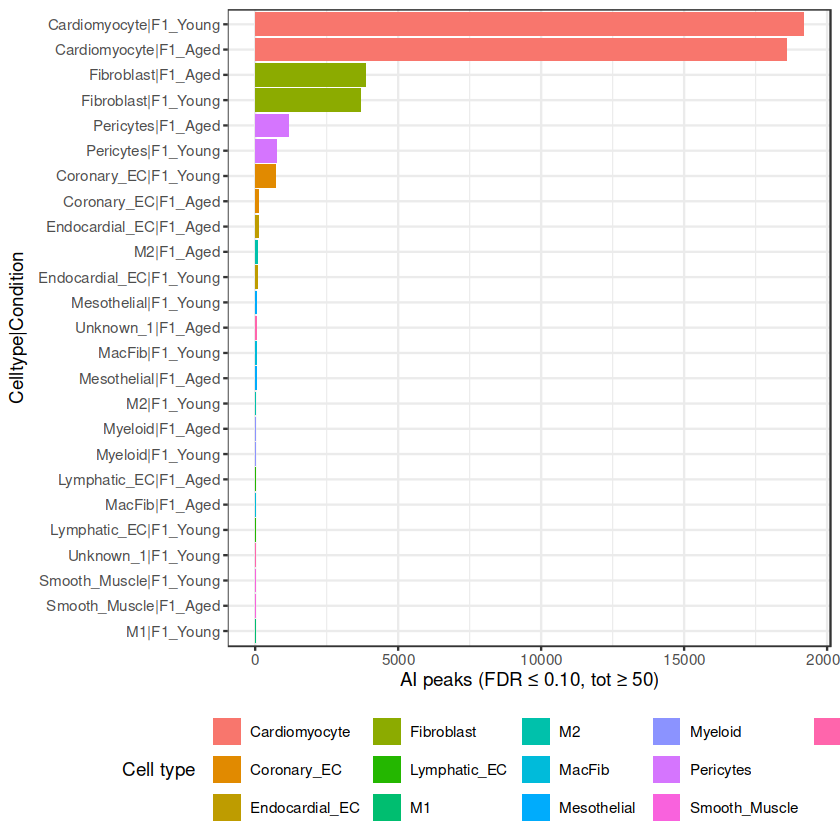

In [7]:
ggplot(group_summary, aes(x = reorder(group_id, ai_peaks), y = ai_peaks, fill = celltype)) +
  geom_col() +
  coord_flip() +
  labs(x = 'Celltype|Condition', y = sprintf('AI peaks (FDR ≤ %.2f, tot ≥ %s)', fdr_cutoff, min_total_counts), fill = 'Cell type') +
  theme(legend.position = 'bottom')


## Top significant peaks per group

In [8]:
top_sig <- ai_all %>%
  filter(ai_significant) %>%
  arrange(fdr, desc(abs_dev)) %>%
  group_by(celltype, condition) %>%
  slice_head(n = 20) %>%
  ungroup() %>%
  dplyr::select(celltype, condition, peak_id, mu_hat, abs_dev, total_counts, norm_tot, fdr)
top_sig


celltype,condition,peak_id,mu_hat,abs_dev,total_counts,norm_tot,fdr
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cardiomyocyte,F1_Aged,chrM:36-6340,0.92375380,0.4237538,126485,15442.63474,0.000000e+00
Cardiomyocyte,F1_Aged,chr2:124738658-124738975,0.03967168,0.4603283,731,89.24826,5.874777e-284
Cardiomyocyte,F1_Aged,chr18:68667837-68668057,0.03981623,0.4601838,653,79.72519,1.768145e-253
Cardiomyocyte,F1_Aged,chr7:48752852-48753087,0.07647908,0.4235209,693,84.60881,1.020462e-230
Cardiomyocyte,F1_Aged,chr19:51308213-51308617,0.09295775,0.4070423,710,86.68436,6.499614e-221
Cardiomyocyte,F1_Aged,chr7:142882453-142882657,0.05315615,0.4468439,602,73.49857,6.716066e-221
Cardiomyocyte,F1_Aged,chr15:96866380-96866748,0.09700428,0.4029957,701,85.58554,1.292469e-214
Cardiomyocyte,F1_Aged,chr1:105303320-105303547,0.02207506,0.4779249,453,55.30706,3.189543e-190
Cardiomyocyte,F1_Aged,chr11:105657293-105658267,0.14147018,0.3585298,721,88.02735,2.238564e-183


## Coverage distributions

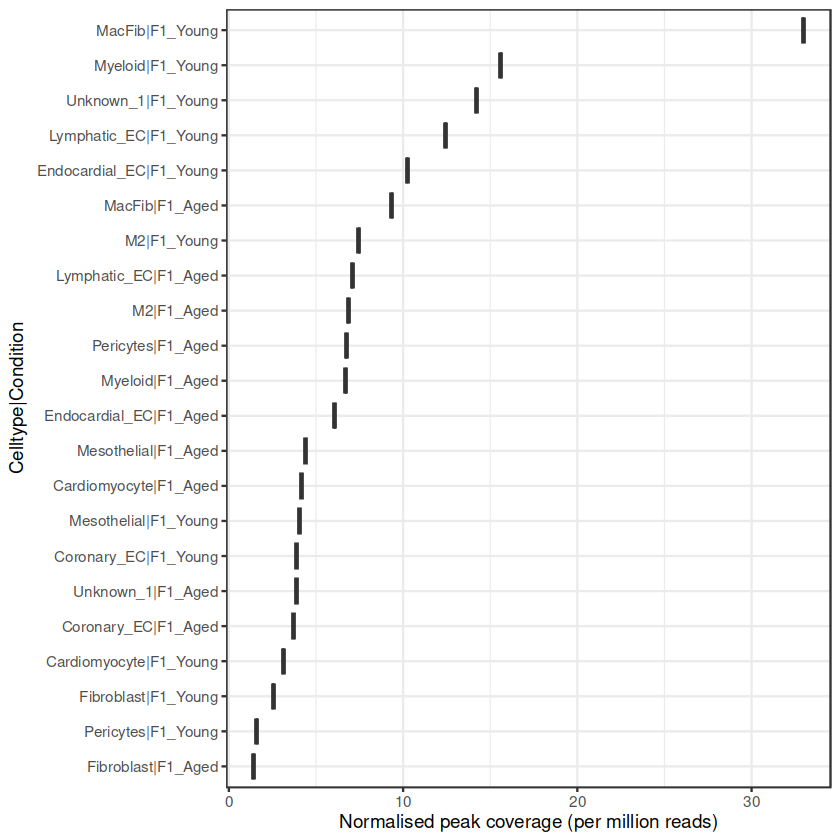

In [9]:
if (!is.null(pb_counts)) {
  coverage_plot <- pb_counts %>%
    group_by(group_id) %>%
    summarise(total_reads = sum(tot), median_tot = stats::median(tot), .groups = 'drop')
  coverage_plot
  ggplot(pb_counts, aes(x = reorder(group_id, norm_tot, FUN = median), y = norm_tot)) +
    geom_boxplot(outlier.alpha = 0.2) +
    coord_flip() +
    labs(x = 'Celltype|Condition', y = 'Normalised peak coverage (per million reads)') +
    theme(legend.position = 'none')
} else {
  message('No pseudobulk coverage available.')
}


## Normalised counts and ASPEN rerun


In [10]:
normalized_inputs <- NULL
if (!file.exists(sce_path)) {
  warning('SCE not found at ', sce_path, '; skipping normalised counts.')
} else {
  message('Loading allelic SCE from ', sce_path)
  sce_norm <- readRDS(sce_path)
  assay_names <- SummarizedExperiment::assayNames(sce_norm)
  if (!all(c('a1','tot') %in% assay_names)) {
    stop('SCE must contain "a1" and "tot" assays to compute normalised counts.')
  }
  cd_norm <- as.data.frame(SummarizedExperiment::colData(sce_norm))
  celltype_col <- intersect(c('celltype_new','celltype','celltype_old'), names(cd_norm))[1]
  condition_col <- intersect(c('condition_new','condition','condition_old'), names(cd_norm))[1]
  sex_col <- intersect(c('sex','sex_final','sex_use'), names(cd_norm))[1]
  if (is.na(celltype_col) || is.na(condition_col)) stop('Celltype/condition annotations not found in SCE colData.')
  celltype_val <- as.character(cd_norm[[celltype_col]])
  condition_val <- as.character(cd_norm[[condition_col]])
  condition_val[is.na(condition_val) | condition_val == ''] <- 'NA'
  group_keys_norm <- paste(celltype_val, condition_val, sep = '|')

  tot_raw <- SummarizedExperiment::assay(sce_norm, 'tot')
  a1_raw  <- SummarizedExperiment::assay(sce_norm, 'a1')

  library_size <- Matrix::colSums(tot_raw)
  ref_median <- stats::median(library_size[library_size > 0], na.rm = TRUE)
  if (!is.finite(ref_median) || ref_median <= 0) ref_median <- 1
  size_factors <- library_size / ref_median
  size_factors[!is.finite(size_factors) | size_factors <= 0] <- 1
  inv_sf <- 1 / size_factors
  inv_sf[!is.finite(inv_sf)] <- 0
  diag_sf <- Matrix::Diagonal(x = inv_sf)

  tot_norm <- tot_raw %*% diag_sf
  a1_norm  <- a1_raw  %*% diag_sf
  colnames(tot_norm) <- colnames(tot_raw)
  colnames(a1_norm)  <- colnames(a1_raw)
  rownames(tot_norm) <- rownames(tot_raw)
  rownames(a1_norm)  <- rownames(a1_raw)

  pb_tot_norm <- group_sum(tot_norm, group_keys_norm)
  pb_a1_norm  <- group_sum(a1_norm,  group_keys_norm)

  pb_tot_dt <- as.data.frame(Matrix::summary(pb_tot_norm))
  names(pb_tot_dt) <- c('peak_idx','group_idx','norm_tot')
  pb_tot_dt$peak <- rownames(pb_tot_norm)[pb_tot_dt$peak_idx]
  pb_tot_dt$group <- colnames(pb_tot_norm)[pb_tot_dt$group_idx]

  pb_a1_dt <- as.data.frame(Matrix::summary(pb_a1_norm))
  names(pb_a1_dt) <- c('peak_idx','group_idx','norm_a1')
  pb_a1_dt$peak <- rownames(pb_a1_norm)[pb_a1_dt$peak_idx]
  pb_a1_dt$group <- colnames(pb_a1_norm)[pb_a1_dt$group_idx]

  pb_norm_dt <- dplyr::left_join(
    pb_tot_dt[, c('peak','group','norm_tot')],
    pb_a1_dt[, c('peak','group','norm_a1')],
    by = c('peak','group')
  )
  pb_norm_dt$norm_a1[is.na(pb_norm_dt$norm_a1)] <- 0
  group_split <- stringr::str_split_fixed(pb_norm_dt$group, '\\|', 2)
  pb_norm_dt$celltype <- group_split[,1]
  pb_norm_dt$condition <- group_split[,2]
  pb_norm_dt$norm_ai <- ifelse(pb_norm_dt$norm_tot > 0, pb_norm_dt$norm_a1 / pb_norm_dt$norm_tot, NA_real_)

  pb_norm_summary <- pb_norm_dt %>%
    dplyr::group_by(celltype, condition) %>%
    dplyr::summarise(
      peaks_with_norm = dplyr::n(),
      median_norm_tot = stats::median(norm_tot, na.rm = TRUE),
      median_norm_ai = stats::median(norm_ai, na.rm = TRUE),
      mean_norm_ai = mean(norm_ai, na.rm = TRUE),
      .groups = 'drop'
    )

  if (write_normalised_counts) {
    dir.create(dirname(normalized_counts_path), recursive = TRUE, showWarnings = FALSE)
    readr::write_tsv(pb_norm_dt, normalized_counts_path)
    message('Wrote normalised pseudobulk counts to ', normalized_counts_path)
  }

  normalized_inputs <- list(
    sce = sce_norm,
    meta = data.frame(
      cell = colnames(sce_norm),
      celltype = celltype_val,
      condition = condition_val,
      sex = if (!is.na(sex_col)) as.character(cd_norm[[sex_col]]) else NA_character_,
      stringsAsFactors = FALSE
    ),
    size_factors = size_factors,
    tot_raw = tot_raw,
    a1_raw = a1_raw,
    tot_norm = tot_norm,
    a1_norm = a1_norm,
    group_keys = group_keys_norm,
    pb_norm_dt = pb_norm_dt,
    pb_norm_summary = pb_norm_summary
  )
  normalized_inputs$meta$sex[is.na(normalized_inputs$meta$sex) | normalized_inputs$meta$sex == ''] <- 'NA'
  normalized_inputs$meta$sex_use <- dplyr::case_when(
    tolower(normalized_inputs$meta$sex) %in% c('female','f') ~ 'F',
    tolower(normalized_inputs$meta$sex) %in% c('male','m') ~ 'M',
    TRUE ~ NA_character_
  )
  normalized_inputs$meta$condition[is.na(normalized_inputs$meta$condition)] <- 'NA'
  print(dplyr::glimpse(normalized_inputs$pb_norm_summary))
}



Loading allelic SCE from /g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/atac_allelic_allcells_sce_sexupdated.rds

Wrote normalised pseudobulk counts to /g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/F1_AI/pseudobulk/allelic_counts_per_peak_norm.tsv.gz



Rows: 88
Columns: 6
$ celltype        <chr> "B_cell", "B_cell", "B_cell", "B_cell", "B_cell", "Car…
$ condition       <chr> "F0_BL6", "F0_CAST", "F1_Aged", "F1_Young", "NA", "F0_…
$ peaks_with_norm <int> 4848, 17349, 23011, 5024, 3365, 4274, 8196, 2089, 4535…
$ median_norm_tot <dbl> 0.70594571, 0.65684506, 0.07657794, 0.55476553, 1.1538…
$ median_norm_ai  <dbl> 1.00000000, 0.00000000, 0.50000000, 0.50000000, 0.5000…
$ mean_norm_ai    <dbl> 0.97304246, 0.22275461, 0.49884880, 0.49698116, 0.4936…
# A tibble: 88 × 6
   celltype         condition peaks_with_norm median_norm_tot median_norm_ai
   <chr>            <chr>               <int>           <dbl>          <dbl>
 1 B_cell           F0_BL6               4848          0.706           1    
 2 B_cell           F0_CAST             17349          0.657           0    
 3 B_cell           F1_Aged             23011          0.0766          0.5  
 4 B_cell           F1_Young             5024          0.555           0.5  
 5 B_cell          

In [28]:
if (run_normalised_aspen) {
  if (is.null(normalized_inputs)) stop('Normalised inputs not available; run the previous cell first.')

  load_aspen <- function() {
      if (!is.na(asp_repo) && nzchar(asp_repo) && dir.exists(asp_repo)) {
        pkgload::load_all(asp_repo, quiet = TRUE)
      } else {
        stop('ASPEN package not installed and asp_repo unavailable.')
      }
    }

  load_aspen()

  dir.create(normalized_aspen_dir, recursive = TRUE, showWarnings = FALSE)
  orig_aspen_dir <- normalizePath(base_dir, mustWork = FALSE)

  meta_norm <- normalized_inputs$meta
  a1_norm_mat <- normalized_inputs$a1_norm
  tot_norm_mat <- normalized_inputs$tot_norm
  a1_raw_mat <- normalized_inputs$a1_raw
  tot_raw_mat <- normalized_inputs$tot_raw

  celltypes <- sort(unique(meta_norm$celltype))
  task_tbl <- purrr::map_dfr(celltypes, function(ct) {
    cond_levels <- sort(unique(meta_norm$condition[meta_norm$celltype == ct]))
    tibble::tibble(celltype = ct, condition = cond_levels)
  })

  run_one_group <- function(task_row) {
    load_aspen()
    ct <- task_row$celltype
    cond_lbl <- task_row$condition
    meta_ct_all <- meta_norm[meta_norm$celltype == ct, , drop = FALSE]
    meta_ct <- meta_ct_all[meta_ct_all$condition == cond_lbl, , drop = FALSE]
    if (nrow(meta_ct) < min_cells_aspen) {
      message('Skipping ', ct, ' / ', cond_lbl, ': only ', nrow(meta_ct), ' cells (< ', min_cells_aspen, ').')
      return(NULL)
    }
    keep <- meta_ct$sex_use %in% c('F','M')
    if (!any(keep)) {
      message('Skipping ', ct, ' / ', cond_lbl, ': no cells with sex assignment.')
      return(NULL)
    }
    meta_ct <- meta_ct[keep, , drop = FALSE]
    meta_ct$sex_group <- factor(meta_ct$sex_use, levels = c('F','M'))
    cells_ct <- meta_ct$cell

    raw_tot_ct <- tot_raw_mat[, cells_ct, drop = FALSE]
    keep_rows <- Matrix::rowSums(raw_tot_ct >= 2) >= 10
    if (!any(keep_rows)) {
      message('Skipping ', ct, ' / ', cond_lbl, ': no peaks passed raw coverage filter.')
      return(NULL)
    }
    if (!is.na(max_peaks_aspen) && sum(keep_rows) > max_peaks_aspen) {
      ord <- order(Matrix::rowMeans(raw_tot_ct[keep_rows, , drop = FALSE]), decreasing = TRUE)
      sel_idx <- which(keep_rows)[ord][seq_len(max_peaks_aspen)]
      keep_rows <- rep(FALSE, length(keep_rows))
      keep_rows[sel_idx] <- TRUE
    }

    a1_ct_norm <- as.matrix(a1_norm_mat[keep_rows, cells_ct, drop = FALSE])
    tot_ct_norm <- as.matrix(tot_norm_mat[keep_rows, cells_ct, drop = FALSE])
    design <- stats::model.matrix(~ sex_group, data = meta_ct)
    rownames(design) <- cells_ct

    message('ASPEN (normalised): ', ct, ' / ', cond_lbl, ' | peaks=', nrow(tot_ct_norm), ' cells=', ncol(tot_ct_norm))
    res <- tryCatch({
      aspen_glm_pipeline(
        a1_counts = a1_ct_norm,
        tot_counts = tot_ct_norm,
        design = design,
        metadata = meta_ct[, 'sex_group', drop = FALSE],
        split.var = 'sex_group',
        min_counts = 0,
        min_cells = 5,
        min_counts_test = 0,
        min_cells_test = 5,
        min_counts_glob = 5,
        dispersion_method = 'deviance',
        use_effective_trials = TRUE,
        per_group_refit = FALSE,
        thetaFilter = 1e-3,
        delta_set = 50,
        N_set = 30,
        shrinkAll = FALSE,
        run_bb_mean = TRUE,
        glob_mean = 'estimate',
        genes.excl = character(0),
        run_group_mean = FALSE,
        run_group_var = FALSE
      )
    }, error = function(e) {
      warning('ASPEN failed for ', ct, ' / ', cond_lbl, ': ', conditionMessage(e))
      NULL
    })
    if (is.null(res)) return(NULL)

    out_ct <- file.path(normalized_aspen_dir, ct, cond_lbl)
    dir.create(out_ct, recursive = TRUE, showWarnings = FALSE)

    saveRDS(res$estimates,        file.path(out_ct, 'estimates_global_norm.rds'))
    saveRDS(res$estimates_shrunk, file.path(out_ct, 'estimates_global_shrunk_norm.rds'))
    saveRDS(res$res_bb_mean,      file.path(out_ct, 'bb_mean_results_norm.rds'))

    to_csv <- function(df, path) {
      if (is.null(df)) return()
      df2 <- as.data.frame(df)
      if (!is.null(rownames(df2))) df2 <- cbind(peak_id = rownames(df2), df2)
      if ('pval_mean' %in% colnames(df2)) df2$fdr_mean <- stats::p.adjust(df2$pval_mean, method = 'BH')
      readr::write_csv(df2, path)
    }
    csv_norm_shrunk <- file.path(out_ct, 'estimates_global_shrunk_norm.csv')
    csv_norm_bb <- file.path(out_ct, 'bb_mean_results_norm.csv')
    to_csv(res$estimates_shrunk, csv_norm_shrunk)
    to_csv(res$res_bb_mean,      csv_norm_bb)

    if (!is.na(orig_aspen_dir) && dir.exists(orig_aspen_dir)) {
      orig_ct_dir <- file.path(orig_aspen_dir, ct, cond_lbl)
      if (dir.exists(orig_ct_dir)) {
        file.copy(csv_norm_shrunk, file.path(orig_ct_dir, 'estimates_global_shrunk_norm.csv'), overwrite = TRUE)
        file.copy(csv_norm_bb,      file.path(orig_ct_dir, 'bb_mean_results_norm.csv'), overwrite = TRUE)
      }
    }

    log_path <- file.path(out_ct, 'run_log_norm.txt')
    lines <- c(
      sprintf('Cell type: %s', ct),
      sprintf('Condition: %s', cond_lbl),
      sprintf('Cells: %d', ncol(tot_ct_norm)),
      sprintf('Peaks (post-filter): %d', nrow(tot_ct_norm)),
      sprintf('Design cols: %s', paste(colnames(design), collapse = ', '))
    )
    writeLines(lines, log_path)
    NULL
  }

  norm_workers <- max(1L, as.integer(Sys.getenv('PBS_NCPUS', unset = '4')))
  max_size <- getOption('future.globals.maxSize', 500 * 1024^2)
  globals_est <- sum(as.numeric(object.size(tot_raw_mat)),
                     as.numeric(object.size(tot_norm_mat)),
                     as.numeric(object.size(a1_norm_mat)))
  use_parallel <- norm_workers > 1 && requireNamespace('future.apply', quietly = TRUE) && globals_est <= max_size
  if (!use_parallel && norm_workers > 1) {
    message('Running sequentially (future.globals.maxSize is ', signif(max_size / 1024^2, 3), ' MiB; globals ~ ', signif(globals_est / 1024^2, 3), ' MiB).')
  }

  if (use_parallel) {
    message('Running normalised ASPEN with ', norm_workers, ' workers (future.apply).')
    future::plan(future::multisession, workers = norm_workers)
    on.exit(future::plan(future::sequential), add = TRUE)
    invisible(future.apply::future_lapply(seq_len(nrow(task_tbl)), function(i) run_one_group(task_tbl[i, , drop = FALSE]), future.seed = TRUE))
  } else {
    invisible(lapply(seq_len(nrow(task_tbl)), function(i) run_one_group(task_tbl[i, , drop = FALSE])))
  }
  message('Finished normalised ASPEN rerun.')
}



Running sequentially (future.globals.maxSize is 500 MiB; globals ~ 1730 MiB).

Skipping B_cell / F0_BL6: only 2 cells (< 40).

Skipping B_cell / F0_CAST: only 7 cells (< 40).

Skipping B_cell / F1_Aged: only 1 cells (< 40).

Skipping B_cell / F1_Young: only 1 cells (< 40).

Skipping B_cell / NA: only 2 cells (< 40).

Skipping Cardiac_Neuronal / F0_BL6: only 1 cells (< 40).

Skipping Cardiac_Neuronal / F0_CAST: only 5 cells (< 40).

Skipping Cardiac_Neuronal / F1_Aged: only 1 cells (< 40).

Skipping Cardiac_Neuronal / F1_Young: only 3 cells (< 40).

Skipping Cardiac_Neuronal / NA: only 5 cells (< 40).

ASPEN (normalised): Cardiomyocyte / F0_BL6 | peaks=10000 cells=2239

ASPEN (normalised): Cardiomyocyte / F0_CAST | peaks=10000 cells=2782

ASPEN (normalised): Cardiomyocyte / F1_Aged | peaks=10000 cells=2874

ASPEN (normalised): Cardiomyocyte / F1_Young | peaks=10000 cells=2770

Skipping Cardiomyocyte / NA: no cells with sex assignment.

ASPEN (normalised): Coronary_EC / F0_BL6 | peaks=44

## Promoter vs distal annotation and cCRE overlap
Peak coordinates are in BL6 chr space; we rename BL6_* contigs to chr* and drop CAST_* entries before computing TSS distances.


In [18]:

peak_annotation <- NULL
if (nrow(ai_all) > 0 && file.exists(gtf_path)) {
  message('Annotating peaks using ', gtf_path)
  txdb <- GenomicFeatures::makeTxDbFromGFF(gtf_path)
  try(GenomeInfoDb::seqlevelsStyle(txdb) <- 'UCSC', silent = TRUE)
  if (!all(grepl('^chr', GenomeInfoDb::seqlevels(txdb)))) {
    seqs <- GenomeInfoDb::seqlevels(txdb)
    seqs_chr <- ifelse(grepl('^chr', seqs), seqs, paste0('chr', seqs))
    GenomeInfoDb::seqlevels(txdb) <- seqs_chr
  }
  chr_levels <- grep('^chr', GenomeInfoDb::seqlevels(txdb), value = TRUE)
  if (!length(chr_levels)) stop('No chr-style seqlevels found after harmonisation; check gtf_path')
  txdb <- GenomeInfoDb::keepSeqlevels(txdb, chr_levels, pruning.mode = 'coarse')

  tss <- GenomicFeatures::promoters(GenomicFeatures::genes(txdb), upstream = 1000, downstream = 1000)
  if (!is.na(gtf_gene_map_path) && nzchar(gtf_gene_map_path) && file.exists(gtf_gene_map_path)) {
    message('Applying gene ID mapping from ', gtf_gene_map_path)
    gene_map <- readr::read_tsv(gtf_gene_map_path, col_names = FALSE, show_col_types = FALSE)
    colnames(gene_map) <- c('assembly', 't2t_id', 'grcm39_id', 'gene_name')
    gene_map$name_preferred <- dplyr::coalesce(gene_map$gene_name, gene_map$grcm39_id, gene_map$t2t_id)
    lookup <- stats::setNames(gene_map$name_preferred, gene_map$t2t_id)
    gid <- as.character(S4Vectors::mcols(tss)$gene_id)
    idx <- !is.na(gid) & gid %in% names(lookup)
    if (any(idx)) {
      S4Vectors::mcols(tss)$gene_name[idx] <- lookup[gid[idx]]
    }
  }

  peaks_gr <- make_peak_granges(unique(ai_all$peak_id))
  GenomeInfoDb::seqlevelsStyle(peaks_gr) <- 'UCSC'

  dist_nearest <- GenomicRanges::distanceToNearest(peaks_gr, tss, ignore.strand = TRUE)
  peak_class <- rep('distal', length(peaks_gr))
  if (length(dist_nearest)) {
    prom_hits <- which(S4Vectors::mcols(dist_nearest)$distance <= 1000)
    if (length(prom_hits)) peak_class[S4Vectors::queryHits(dist_nearest)[prom_hits]] <- 'promoter'
  }
  peak_annotation <- tibble::tibble(peak_id = names(peaks_gr), peak_class = peak_class)
  if (!is.na(ccre_path) && file.exists(ccre_path)) {
    message('Overlapping peaks with cCREs: ', ccre_path)
    ccres <- rtracklayer::import(ccre_path)
    GenomeInfoDb::seqlevelsStyle(ccres) <- 'UCSC'
    overlaps <- GenomicRanges::findOverlaps(peaks_gr, ccres, ignore.strand = TRUE)
    has_cCRE <- tabulate(S4Vectors::queryHits(overlaps), nbins = length(peaks_gr)) > 0
    peak_annotation$cCRE_overlap <- has_cCRE
  }
  ai_all <- ai_all %>% dplyr::left_join(peak_annotation, by = 'peak_id')
  class_tab <- table(ai_all$ai_significant, ai_all$peak_class, dnn = c('AI', 'Class'))
  class_tab
  if (all(c('promoter', 'distal') %in% peak_annotation$peak_class)) {
    fisher_res <- stats::fisher.test(class_tab)
    print(fisher_res)
  } else {
    message('Not enough promoter/distal variety for Fisher test.')
  }
} else {
  warning('Skipping peak annotation: check ai_all and gtf_path.')
}



Annotating peaks using /g/data/zk16/muqing/Projects/Multiome/ref/BL6_T2T/geneset/genes.gtf

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK




	Fisher's Exact Test for Count Data

data:  class_tab
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4307911 0.4682690
sample estimates:
odds ratio 
 0.4491722 



In [19]:
peak_annotation

peak_id,peak_class
<chr>,<chr>
chr1:100064274-100065433,distal
chr1:100147093-100147549,promoter
chr1:100190473-100191453,promoter
chr1:100591221-100592810,promoter
chr1:100624601-100625379,distal
chr1:100671998-100673161,distal
chr1:100943378-100944226,promoter
chr1:101002724-101003178,distal
chr1:101043996-101045260,distal


## Peak–gene links and RNA concordance (optional)

In [ ]:
if (run_linkpeaks && !is.na(multiome_path) && file.exists(multiome_path)) {
  required_pkgs <- c('Seurat', 'SeuratObject', 'Signac', 'dplyr', 'tibble', 'stringr', 'readr', 'rtracklayer', 'Rsamtools', 'Biostrings', 'purrr')
  missing_pkgs <- required_pkgs[!vapply(required_pkgs, requireNamespace, logical(1), quietly = TRUE)]
  if (length(missing_pkgs)) {
    warning('Install required packages before running LinkPeaks: ', paste(missing_pkgs, collapse = ', '))
  } else {
    message('Loading multiome object from ', multiome_path)
    multiome_obj <- readRDS(multiome_path)
    if (!('ATAC_agg' %in% Seurat::Assays(multiome_obj))) stop('ATAC_agg assay not present in multiome object; cannot run LinkPeaks.')
    if (!('RNA' %in% Seurat::Assays(multiome_obj))) stop('RNA assay not present in multiome object; cannot run LinkPeaks.')
    Seurat::DefaultAssay(multiome_obj) <- 'ATAC_agg'

    if ('JoinLayers' %in% ls('package:SeuratObject')) {
      try({
        multiome_obj <- SeuratObject::JoinLayers(object = multiome_obj, assay = 'RNA')
        message('Joined RNA layers for LinkPeaks compatibility.')
      }, silent = TRUE)
      try({
        multiome_obj <- SeuratObject::JoinLayers(object = multiome_obj, assay = 'ATAC_agg')
        message('Joined ATAC_agg layers for LinkPeaks compatibility.')
      }, silent = TRUE)
    }

    gtf_path_local <- if (exists('gtf_path', inherits = TRUE)) get('gtf_path', inherits = TRUE) else NA_character_
    gtf_gene_map_local <- if (exists('gtf_gene_map_path', inherits = TRUE)) get('gtf_gene_map_path', inherits = TRUE) else NA_character_

    chrom_assay <- multiome_obj[['ATAC_agg']]
    if (is.null(Signac::Annotation(chrom_assay))) {
      if (!is.na(gtf_path_local) && nzchar(gtf_path_local) && file.exists(gtf_path_local)) {
        message('Adding gene annotations from ', gtf_path_local)
        annot_gr <- rtracklayer::import(gtf_path_local)
        try(GenomeInfoDb::seqlevelsStyle(annot_gr) <- 'UCSC', silent = TRUE)
        mcols <- S4Vectors::mcols(annot_gr)
        if (!'gene_name' %in% names(mcols)) {
          alt <- intersect(c('gene_name', 'gene', 'gene_id', 'Name'), names(mcols))
          mcols$gene_name <- if (length(alt)) as.character(mcols[[alt[1]]]) else NA_character_
        }
        if (!'gene_biotype' %in% names(mcols)) {
          alt <- intersect(c('gene_biotype', 'gene_type', 'biotype'), names(mcols))
          mcols$gene_biotype <- if (length(alt)) as.character(mcols[[alt[1]]]) else NA_character_
        }
        if (!'type' %in% names(mcols) && 'feature' %in% names(mcols)) {
          mcols$type <- mcols$feature
        }
        required_cols <- c('gene_id', 'gene_name', 'gene_biotype', 'type')
        missing_cols <- required_cols[!required_cols %in% names(mcols)]
        if (length(missing_cols)) {
          for (col in missing_cols) mcols[[col]] <- NA_character_
        }
        S4Vectors::mcols(annot_gr) <- mcols
        if (!is.na(gtf_gene_map_local) && nzchar(gtf_gene_map_local) && file.exists(gtf_gene_map_local)) {
          message('Applying gene ID mapping from ', gtf_gene_map_local)
          gene_map <- readr::read_tsv(gtf_gene_map_local, col_names = FALSE, show_col_types = FALSE)
          colnames(gene_map) <- c('assembly', 't2t_id', 'grcm39_id', 'gene_name')
          gene_map$name_preferred <- dplyr::coalesce(gene_map$gene_name, gene_map$grcm39_id, gene_map$t2t_id)
          lookup <- stats::setNames(gene_map$name_preferred, gene_map$t2t_id)
          gid <- as.character(S4Vectors::mcols(annot_gr)$gene_id)
          idx <- !is.na(gid) & gid %in% names(lookup)
          if (any(idx)) {
            S4Vectors::mcols(annot_gr)$gene_name[idx] <- lookup[gid[idx]]
          }
        }
        Signac::Annotation(chrom_assay) <- annot_gr
        multiome_obj[['ATAC_agg']] <- chrom_assay
      } else {
        warning('ATAC_agg assay lacks annotation and gtf_path is unavailable; LinkPeaks may fail.')
      }
    }

    chrom_assay <- multiome_obj[['ATAC_agg']]
    attach_filtered_fragments <- function() {
      all_cells <- Seurat::Cells(multiome_obj)
      all_cells_upper <- toupper(all_cells)
      cell_lookup <- stats::setNames(all_cells, all_cells_upper)
      sample_orig_all <- sub('_([^_]*)$', '', all_cells)
      samples_df <- dplyr::distinct(tibble::tibble(sample_orig = sample_orig_all, sample_upper = toupper(sample_orig_all)))

      read_clean_lines <- function(fp) {
        vals <- readr::read_lines(fp)
        vals <- toupper(trimws(vals))
        vals[nzchar(vals)]
      }

      build_map <- function(samples_df) {
        res <- purrr::map(seq_len(nrow(samples_df)), function(i) {
          sid_orig  <- samples_df$sample_orig[i]
          sid_upper <- samples_df$sample_upper[i]
          gex_path  <- file.path(gex_qc_dir, sid_orig, 'intersect_keep_barcodes.txt')
          atac_path <- file.path(atac_qc_dir, sid_orig, 'intersect_keep_ATAC_barcodes.txt')
          if (!file.exists(gex_path) || !file.exists(atac_path)) return(NULL)
          gex  <- read_clean_lines(gex_path)
          atac <- read_clean_lines(atac_path)
          if (length(gex) != length(atac)) {
            stop(sprintf('Barcode mismatch for %s: GEX=%d, ATAC=%d', sid_orig, length(gex), length(atac)))
          }
          tibble::tibble(
            sample_orig = sid_orig,
            sample_upper = sid_upper,
            tidy_upper = paste0(sid_upper, '_', gex),
            atac_raw = atac
          )
        })
        res <- purrr::compact(res)
        if (!length(res)) return(NULL)
        mapping <- dplyr::bind_rows(res)
        mapping$tidy_upper <- toupper(mapping$tidy_upper)
        mapping$atac_raw <- toupper(mapping$atac_raw)
        mapping
      }

      mapping <- build_map(samples_df)
      if (is.null(mapping) || !nrow(mapping)) stop('No barcode mappings found for the multiome object.')
      mapping <- mapping[mapping$tidy_upper %in% all_cells_upper, , drop = FALSE]
      if (!nrow(mapping)) stop('Barcode mapping contains no cells present in the multiome object.')

      lookup_raw <- stats::setNames(mapping$atac_raw, mapping$tidy_upper)

      manifest <- NULL
      if (!is.na(fragment_manifest_path) && nzchar(fragment_manifest_path) && file.exists(fragment_manifest_path)) {
        manifest <- tryCatch(readr::read_tsv(fragment_manifest_path, show_col_types = FALSE), error = function(e) NULL)
      }
      if (is.null(manifest) || !nrow(manifest)) {
        candidates <- list.files(filtered_fragment_dir, pattern = 'fragments\\.filtered\\.tsv\\.gz$', recursive = TRUE, full.names = TRUE)
        if (!length(candidates)) stop('No filtered fragment files detected under ', filtered_fragment_dir)
        manifest <- tibble::tibble(sample = basename(dirname(candidates)), fragments = candidates)
      }

      manifest$sample <- as.character(manifest$sample)
      manifest <- manifest[manifest$sample %in% samples_df$sample_orig, , drop = FALSE]
      if (!nrow(manifest)) stop('Filtered fragment manifest has no samples matching the multiome object.')

      frag_list <- list()
      for (sid_orig in unique(manifest$sample)) {
        frag_path <- manifest$fragments[manifest$sample == sid_orig][1]
        if (!file.exists(frag_path)) {
          warning('Fragment file missing for ', sid_orig, ': ', frag_path)
          next
        }
        tidy_cells_upper <- mapping$tidy_upper[mapping$sample_orig == sid_orig]
        tidy_cells_upper <- tidy_cells_upper[tidy_cells_upper %in% all_cells_upper]
        if (!length(tidy_cells_upper)) {
          warning('No tidy cells for sample ', sid_orig, ' overlap with multiome object.')
          next
        }
        original_names <- cell_lookup[tidy_cells_upper]
        raw_barcodes <- lookup_raw[tidy_cells_upper]
        raw_barcodes <- raw_barcodes[nzchar(raw_barcodes)]
        if (!length(raw_barcodes)) {
          warning('Mapped raw barcodes empty for sample ', sid_orig)
          next
        }
        cell_map <- stats::setNames(raw_barcodes, original_names)
        frag_obj <- Signac::CreateFragmentObject(path = frag_path, cells = cell_map, validate.fragments = FALSE)
        frag_list[[length(frag_list) + 1]] <- frag_obj
      }

      frag_list <- purrr::compact(frag_list)
      message('Attaching ', length(frag_list), ' fragment objects for ', paste(unique(manifest$sample), collapse=', '))
      if (!length(frag_list)) stop('No fragment objects created; check manifest and barcode mappings.')
      chrom_tmp <- chrom_assay
      Signac::Fragments(chrom_tmp) <- frag_list
      chrom_assay <<- chrom_tmp
      multiome_obj[['ATAC_agg']] <<- chrom_assay
      multiome_obj[['ATAC_agg']] <- chrom_assay
    }
    if (length(Signac::Fragments(chrom_assay)) == 0L) {
      if (!is.na(filtered_fragment_dir) && nzchar(filtered_fragment_dir) && dir.exists(filtered_fragment_dir)) {
        message('Attaching filtered fragment files to ATAC_agg assay.')
        attach_filtered_fragments()
        chrom_assay <- multiome_obj[['ATAC_agg']]
      }
    }
    fragments_available <- length(Signac::Fragments(chrom_assay))
    if (fragments_available == 0L) {
      stop('No fragment files detected for ATAC_agg assay; attach fragment paths before running LinkPeaks.')
    }
    bsgenome_candidates <- if (exists('bsgenome_preference', inherits = TRUE)) bsgenome_preference else character(0)
    if (!length(bsgenome_candidates)) {
      bsgenome_candidates <- c('BSgenome.Mmusculus.T2T.C57BL6Jv1', 'BSgenome.Mmusculus.UCSC.mm10')
    }
    bsgenome_obj <- NULL
    bsgenome_pkg <- NA_character_
    for (pkg in bsgenome_candidates) {
      if (is.na(pkg) || !nzchar(pkg)) next
      if (requireNamespace(pkg, quietly = TRUE)) {
        bsgenome_obj <- getExportedValue(pkg, pkg)
        bsgenome_pkg <- pkg
        break
      }
    }
    if (!is.null(bsgenome_obj)) {
      peaks_gr <- Signac::granges(chrom_assay)
      genome_seqinfo <- tryCatch(GenomeInfoDb::seqinfo(bsgenome_obj), error = function(e) NULL)
      if (!is.null(genome_seqinfo)) {
        peak_chr <- as.character(GenomeInfoDb::seqnames(peaks_gr))
        if (length(peak_chr)) {
          common_chr <- intersect(peak_chr, names(genome_seqinfo))
          if (length(common_chr)) {
            peak_idx <- peak_chr %in% common_chr
            max_end <- tapply(BiocGenerics::end(peaks_gr)[peak_idx], peak_chr[peak_idx], max, na.rm = TRUE)
            seqlen_lookup <- GenomeInfoDb::seqlengths(genome_seqinfo)[names(max_end)]
            mismatch <- !is.na(seqlen_lookup) & max_end > seqlen_lookup
            if (any(mismatch)) {
              message('Detected peaks exceeding seqlengths for ', bsgenome_pkg, '; trying FASTA fallback if available.')
              bsgenome_obj <- NULL
              bsgenome_pkg <- NA_character_
            }
          }
        }
      }
    }
    if (is.null(bsgenome_obj)) {
      fallback_fasta <- if (exists('regionstats_fasta', inherits = TRUE)) get('regionstats_fasta', inherits = TRUE) else NA_character_
      if (!is.na(fallback_fasta) && nzchar(fallback_fasta) && file.exists(fallback_fasta)) {
        if (!requireNamespace('Rsamtools', quietly = TRUE) || !requireNamespace('Biostrings', quietly = TRUE)) {
          stop('RegionStats FASTA fallback requires Rsamtools and Biostrings; install them via BiocManager::install(c("Rsamtools", "Biostrings")).')
        }
        fai_path <- paste0(fallback_fasta, '.fai')
        if (!file.exists(fai_path)) {
          message('Indexing FASTA for RegionStats: ', fallback_fasta)
          Rsamtools::indexFa(fallback_fasta)
        }
        fa_obj <- Rsamtools::FaFile(fallback_fasta)
        try(GenomeInfoDb::seqlevelsStyle(fa_obj) <- 'UCSC', silent = TRUE)
        bsgenome_obj <- fa_obj
        bsgenome_pkg <- paste0('FaFile:', basename(fallback_fasta))
      }
    }
    if (is.null(bsgenome_obj)) {
      msg <- paste0('RegionStats requires a genome reference. Checked BSgenome candidates: ',
                    paste(bsgenome_candidates[!is.na(bsgenome_candidates) & nzchar(bsgenome_candidates)], collapse = ', '),
                    '. Install one (e.g. BiocManager::install("BSgenome.Mmusculus.UCSC.mm10")) or supply an indexed FASTA via regionstats_fasta.')
      fallback_fasta <- if (exists('regionstats_fasta', inherits = TRUE)) get('regionstats_fasta', inherits = TRUE) else NA_character_
      if (is.na(fallback_fasta) || !nzchar(fallback_fasta) || !file.exists(fallback_fasta)) {
        msg <- paste0(msg, ' No usable FASTA was provided.')
      } else {
        msg <- paste0(msg, ' FASTA provided but could not be used; ensure it exists and Rsamtools/Biostrings are installed.')
      }
      stop(msg)
    }

    message('Computing peak sequence statistics via RegionStats (', bsgenome_pkg, ').')
    chrom_assay <- Signac::RegionStats(object = chrom_assay, genome = bsgenome_obj, verbose = TRUE)
    multiome_obj[['ATAC_agg']] <- chrom_assay
    if (inherits(bsgenome_obj, 'FaFile') && Rsamtools::isOpen(bsgenome_obj)) {
      try(Rsamtools::close(bsgenome_obj), silent = TRUE)
    }

    message('Running LinkPeaks (this can take time)...')
    multiome_obj <- Signac::LinkPeaks(object = multiome_obj, peak.assay = 'ATAC_agg', expression.assay = 'RNA')
    links_df <- Signac::Links(multiome_obj)
    links_df <- tibble::as_tibble(links_df)
    linkpeaks_results <- NULL
    if (!nrow(links_df)) {
      warning('LinkPeaks returned 0 peak-gene links; skipping concordance step.')
      linkpeaks_results <- list(object = multiome_obj, peak_gene_links = links_df)
    } else {
      ai_atac <- NULL
      if (exists('ai_all', inherits = TRUE) && !is.null(ai_all) && nrow(ai_all)) {
        ai_atac <- ai_all
        if (!'peak_class' %in% names(ai_atac)) ai_atac$peak_class <- NA_character_
        if (!'cCRE_overlap' %in% names(ai_atac)) ai_atac$cCRE_overlap <- NA
        ai_atac <- ai_atac %>%
          dplyr::select(
            peak_id,
            celltype,
            condition,
            group_id,
            mu_atac = mu_hat,
            abs_dev_atac = abs_dev,
            fdr_atac = fdr,
            total_counts,
            norm_tot,
            ai_significant_atac = ai_significant,
            peak_class,
            cCRE_overlap
          )
      }

      pick_column <- function(tbl, candidates) {
        cols <- candidates[candidates %in% names(tbl)]
        if (length(cols)) cols[1] else NA_character_
      }

      rna_ai <- NULL
      if (!is.na(rna_ai_path) && nzchar(rna_ai_path) && file.exists(rna_ai_path)) {
        message('Reading RNA AI table from ', rna_ai_path)
        rna_ai <- tryCatch({
          df <- readr::read_tsv(rna_ai_path, progress = FALSE, show_col_types = FALSE)
          gene_col <- pick_column(df, c('gene', 'gene_id', 'feature', 'symbol'))
          mu_col <- pick_column(df, c('mu_hat', 'bb_mu', 'mu', 'mu_hat_rna'))
          if (is.na(gene_col) || is.na(mu_col)) {
            warning('RNA AI table must contain gene/mu_hat columns; skipping RNA concordance.')
            NULL
          } else {
            cell_col <- pick_column(df, c('celltype', 'celltype_new', 'group_celltype'))
            cond_col <- pick_column(df, c('condition', 'condition_new', 'group_condition'))
            group_col <- pick_column(df, c('group_id', 'group'))
            abs_col <- pick_column(df, c('abs_dev', 'abs_dev_rna', 'abs_deviation'))
            fdr_col <- pick_column(df, c('fdr', 'fdr_mean', 'padj', 'padj_mean'))

            df <- tibble::as_tibble(df)
            df$gene <- df[[gene_col]]
            df$celltype <- if (!is.na(cell_col)) df[[cell_col]] else NA_character_
            df$condition <- if (!is.na(cond_col)) df[[cond_col]] else NA_character_
            df$group_id <- if (!is.na(group_col)) df[[group_col]] else NA_character_
            df$mu_rna <- as.numeric(df[[mu_col]])
            df$abs_dev_rna <- if (!is.na(abs_col)) as.numeric(df[[abs_col]]) else abs(df$mu_rna - 0.5)
            df$fdr_rna <- if (!is.na(fdr_col)) as.numeric(df[[fdr_col]]) else NA_real_
            df$condition[df$condition %in% c('', NA)] <- 'NA'
            df$group_id[df$group_id %in% c('', NA)] <- paste(df$celltype, df$condition, sep = '|')
            df %>%
              dplyr::select(celltype, condition, group_id, gene, mu_rna, abs_dev_rna, fdr_rna) %>%
              dplyr::mutate(ai_significant_rna = !is.na(fdr_rna) & fdr_rna <= fdr_cutoff)
          }
        }, error = function(e) {
          warning('Failed to read RNA AI table: ', conditionMessage(e))
          NULL
        })
      }

      message('Computing peak-gene concordance...')
      concordance_df <- NULL
      concordance_summary <- tibble::tibble()
      if (!is.null(ai_atac)) {
        concordance_df <- ai_atac %>%
          dplyr::left_join(links_df, by = c('peak_id' = 'peak'))
        if (!is.null(rna_ai)) {
          concordance_df <- concordance_df %>%
            dplyr::left_join(rna_ai, by = c('gene', 'celltype', 'condition', 'group_id'))
        }

        concordance_df <- concordance_df %>%
          dplyr::mutate(
            delta_atac = mu_atac - 0.5,
            delta_rna = ifelse(!is.null(rna_ai), mu_rna - 0.5, NA_real_),
            concordant = dplyr::case_when(
              is.na(delta_atac) | is.na(delta_rna) ~ NA,
              sign(delta_atac) == sign(delta_rna) ~ TRUE,
              TRUE ~ FALSE
            ),
            concordance_label = dplyr::case_when(
              is.na(concordant) ~ NA_character_,
              concordant ~ 'co-biased',
              TRUE ~ 'anti-biased'
            ),
            concordance_score = ifelse(is.na(delta_atac) | is.na(delta_rna), NA_real_,
                                       abs(delta_atac) * abs(delta_rna) * ifelse(concordant, 1, -1))
          )

        concordance_summary <- concordance_df %>%
          dplyr::filter(!is.na(concordant)) %>%
          dplyr::group_by(celltype, condition) %>%
          dplyr::summarise(
            n_links = dplyr::n(),
            n_co_biased = sum(concordant, na.rm = TRUE),
            n_anti_biased = sum(!concordant, na.rm = TRUE),
            fraction_co_biased = ifelse(n_links > 0, n_co_biased / n_links, NA_real_),
            mean_concordance_score = mean(concordance_score, na.rm = TRUE),
            .groups = 'drop'
          )

        out_dir <- if (!is.na(normalized_aspen_dir) && nzchar(normalized_aspen_dir)) normalized_aspen_dir else file.path(dirname(base_dir), 'aspen_norm')
        dir.create(out_dir, recursive = TRUE, showWarnings = FALSE)
        out_file <- file.path(out_dir, 'peak_gene_concordance.tsv.gz')
        readr::write_tsv(concordance_df, out_file)
        message('Saved peak-gene concordance to ', out_file)
        print(concordance_summary)

        if (nrow(concordance_summary)) {
          concordance_plot <- concordance_summary %>%
            ggplot2::ggplot(ggplot2::aes(x = celltype, y = fraction_co_biased, fill = condition)) +
            ggplot2::geom_col(position = 'dodge', alpha = 0.85) +
            ggplot2::coord_flip() +
            ggplot2::scale_y_continuous(labels = function(x) sprintf('%d%%', round(100 * x))) +
            ggplot2::labs(
              x = 'Cell type',
              y = 'Fraction co-biased (ATAC & RNA)',
              fill = 'Condition',
              title = 'Allelic concordance of peak-gene links'
            ) +
            ggplot2::theme_bw()
          plot_path <- file.path(out_dir, 'peak_gene_concordance_summary.png')
          ggplot2::ggsave(plot_path, concordance_plot, width = 8, height = 6, dpi = 300)
          message('Saved concordance summary plot to ', plot_path)
          print(concordance_plot)
        } else {
          message('No concordant peak-gene pairs to plot.')
        }

        linkpeaks_results <- list(
          object = multiome_obj,
          peak_gene_links = links_df,
          concordance = concordance_df,
          concordance_summary = concordance_summary
        )
      } else {
        warning('ai_all object not available; cannot join ATAC AI metrics with peak-gene links.')
        linkpeaks_results <- list(object = multiome_obj, peak_gene_links = links_df)
      }
    } 
  }
} else {
  message('Skipping LinkPeaks: set run_linkpeaks <- TRUE and provide multiome_path/rna_ai_path to enable.')
}


Loading multiome object from /g/data/zk16/muqing/Projects/Multiome/data/multiome/wnn_multiome_with_allelic_fracs_and_fixed_condition_ATACagg_wnn_sexupdated.rds



## Suggested follow-ups

- Validate autosome vs. X-chromosome behaviour and known imprinting loci to ensure allele-aware alignment worked.
- Compare these ATAC AI calls with RNA ASE once it is available; inspect discordant loci manually.
- Consider running scDALI or another trajectory-aware AI method if within-cell-type heterogeneity is suspected.
- Export significant peak lists for downstream visualisation in genome browsers or integration with Cicero/ArchR loops.

In [30]:
object <- readRDS('/g/data/zk16/muqing/Projects/Multiome/rebuild_veronika/multiome/veronika_multiome_mm39_parallel_update.rds')

In [60]:
object@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,log10GenesPerUMI,mitoRatio,ident,sum,detected,subsets_Mito_sum,subsets_Mito_detected,⋯,nFeature_ATAC_T2T,nCount_ATAC,nFeature_ATAC,nCount_ATAC_agg,nFeature_ATAC_agg,nCount_ATAC_mm39_BL6,nFeature_ATAC_mm39_BL6,nCount_ATAC_mm39_CAST,nFeature_ATAC_mm39_CAST,nCount_ATAC_mm39_total
,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>,<int>,⋯,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
Sample_1_AAACAGCCAATAATCC-1,Sample_1,1382,900,0.9435466,0.0006968641,Sample_1,1435,952,1,1,⋯,456,496,456,288,279,219,211,69,68,288
Sample_1_AAACAGCCACCGGCTA-1,Sample_1,5667,2148,0.8923625,0.0001720874,Sample_1,5811,2286,1,1,⋯,3704,3965,3704,2488,2334,1838,1736,650,622,2488
Sample_1_AAACAGCCAGGATGGC-1,Sample_1,5230,2104,0.8978963,0.0003728561,Sample_1,5364,2232,2,2,⋯,4239,4469,4239,2815,2693,2084,2005,731,712,2815
Sample_1_AAACAGCCATGTTGTG-1,Sample_1,1019,673,0.9436402,0.0009389671,Sample_1,1065,719,1,1,⋯,503,553,503,304,292,222,216,82,79,304
Sample_1_AAACATGCAAGACTCC-1,Sample_1,2560,1319,0.9191828,0.0000000000,Sample_1,2649,1401,0,0,⋯,594,614,594,369,361,273,268,96,94,369
Sample_1_AAACATGCACAAACTT-1,Sample_1,8128,2449,0.8714573,0.0003624064,Sample_1,8278,2596,3,3,⋯,5738,6209,5738,3948,3655,2918,2741,1030,961,3948
Sample_1_AAACATGCATGTCGCG-1,Sample_1,1946,1153,0.9342874,0.0064134188,Sample_1,2027,1229,13,4,⋯,1215,1257,1215,764,742,578,561,186,182,764
Sample_1_AAACCAACAAAGCTCC-1,Sample_1,1090,720,0.9430940,0.0026714159,Sample_1,1123,753,3,3,⋯,75,75,75,52,51,36,36,16,16,52
Sample_1_AAACCAACAAGCGAGC-1,Sample_1,3337,1910,0.9357168,0.0033888732,Sample_1,3541,2094,12,10,⋯,3065,3580,3065,2112,1897,1614,1460,498,461,2112


[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "log10GenesPerUMI"                 
 [5] "mitoRatio"                         "ident"                            
 [7] "sum"                               "detected"                         
 [9] "subsets_Mito_sum"                  "subsets_Mito_detected"            
[11] "subsets_Mito_percent"              "total"                            
[13] "discard"                           "keep"                             
[15] "scDblFinder.class"                 "scDblFinder.score"                
[17] "scDblFinder.weighted"              "scDblFinder.cxds_score"           
[19] "sizeFactor"                        "pred.score"                       
[21] "pred.sex"                          "RNA_snn_res.0.5"                  
[23] "RNA_snn_res.0.8"                   "RNA_snn_res.1"                    
[25] "seurat_clusters"                   "predicted.id"                     
[27] "prediction.score.Cardiomyocyte"    "prediction.score.Unknown_3"       
[29] "prediction.score.Cardiac_Neuronal" "prediction.score.Fibroblast"      
[31] "prediction.score.Macrophage"       "prediction.score.Myeloid"         
[33] "prediction.score.Coronary_EC"      "prediction.score.Mesothelial"     
[35] "prediction.score.Lymphatic_EC"     "prediction.score.T_cell"          
[37] "prediction.score.Endocardial_EC"   "prediction.score.Pericytes"       
[39] "prediction.score.B_cell"           "prediction.score.Smooth_Muscle"   
[41] "prediction.score.Unknown_2"        "prediction.score.Unknown_1"       
[43] "prediction.score.max"              "RNA_snn_res.0.1"                  
[45] "barcode"                           "sample"                           
[47] "nCount_RNA_T2T"                    "nFeature_RNA_T2T"                 
[49] "nCount_RNA_gene_T2T"               "nFeature_RNA_gene_T2T"            
[51] "nCount_RNA_gene"                   "nFeature_RNA_gene"                
[53] "nCount_ATAC_T2T"                   "nFeature_ATAC_T2T"                
[55] "nCount_ATAC"                       "nFeature_ATAC"                    
[57] "nCount_ATAC_agg"                   "nFeature_ATAC_agg"                
[59] "nCount_ATAC_mm39_BL6"              "nFeature_ATAC_mm39_BL6"           
[61] "nCount_ATAC_mm39_CAST"             "nFeature_ATAC_mm39_CAST"          
[63] "nCount_ATAC_mm39_total"

In [66]:
allele_obj <- readRDS('/g/data/zk16/muqing/Projects/Multiome/QC/ATAC/allelic/atac_allelic_allcells_sce_sexupdated.rds')

In [67]:
allele_obj

class: SingleCellExperiment 
dim: 112264 50514 
metadata(3): anchor_used chain_hint mm39_assays
assays(3): a1 a2 tot
rownames(112264): chr1-3188817-3189216 chr1-3189738-3190440 ...
  chr3-159545002-159545211 chr3-159545820-159546177
rowData names(5): agg_id seqnames start end width
colnames(50514): Sample_1_AAACAGCCAATAATCC-1
  Sample_1_AAACAGCCACCGGCTA-1 ... Sample_8_TTTGTTGGTTGCAATG-1
  Sample_8_TTTGTTGGTTGTCCAT-1
colData names(65): orig.ident nCount_RNA ... sample_id condition
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

DataFrame with 50514 rows and 65 columns
                             orig.ident nCount_RNA nFeature_RNA
                            <character>  <integer>    <integer>
Sample_1_AAACAGCCAATAATCC-1    Sample_1       1382          900
Sample_1_AAACAGCCACCGGCTA-1    Sample_1       5667         2148
Sample_1_AAACAGCCAGGATGGC-1    Sample_1       5230         2104
Sample_1_AAACAGCCATGTTGTG-1    Sample_1       1019          673
Sample_1_AAACATGCAAGACTCC-1    Sample_1       2560         1319
...                                 ...        ...          ...
Sample_8_TTTGTTGGTTAGCCAA-1    Sample_8        386          321
Sample_8_TTTGTTGGTTAGCTGA-1    Sample_8        471          370
Sample_8_TTTGTTGGTTCACCAT-1    Sample_8        769          518
Sample_8_TTTGTTGGTTGCAATG-1    Sample_8       4954         1859
Sample_8_TTTGTTGGTTGTCCAT-1    Sample_8       1740         1037
                            log10GenesPerUMI   mitoRatio       ident       sum
                                   <numeric>   <